In [27]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Generate XOR dataset
np.random.seed(0)
X_train = np.random.rand(200, 2) * 2 - 1  # Random points in [-1, 1]
Y_train = np.logical_xor(X_train[:, 0] > 0, X_train[:, 1] > 0).astype(int)  # XOR labels
X_test = np.random.rand(200, 2) * 2 - 1
Y_test = np.logical_xor(X_test[:, 0] > 0, X_test[:, 1] > 0).astype(int)


Test accuracy: 0.96


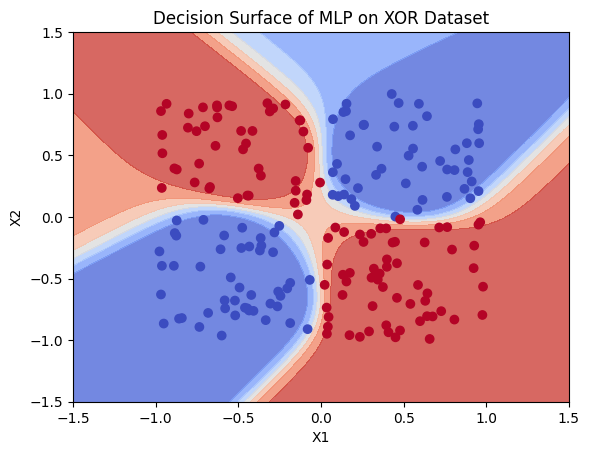

In [28]:
# Sigmoid activation function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Derivative of the sigmoid function
def sigmoid_derivative(x):
    return x * (1 - x)

# Define the model architecture
class NeuralNetwork:
    def __init__(self):
        # Initialize weights and biases
        self.input_size = 2
        self.hidden_size = 4
        self.output_size = 1

        self.weights_input_hidden = np.random.randn(self.input_size, self.hidden_size)
        self.bias_input_hidden = np.zeros((1, self.hidden_size))

        self.weights_hidden_output = np.random.randn(self.hidden_size, self.output_size)
        self.bias_hidden_output = np.zeros((1, self.output_size))

    def forward(self, X):
        # Forward pass
        self.hidden_output = sigmoid(np.dot(X, self.weights_input_hidden) + self.bias_input_hidden)
        self.output = sigmoid(np.dot(self.hidden_output, self.weights_hidden_output) + self.bias_hidden_output)
        return self.output

    def backward(self, X, y, lr):
        # Backpropagation
        error = y - self.output
        d_output = error * sigmoid_derivative(self.output)

        error_hidden = np.dot(d_output, self.weights_hidden_output.T)
        d_hidden = error_hidden * sigmoid_derivative(self.hidden_output)

        # Update weights and biases
        self.weights_hidden_output += np.dot(self.hidden_output.T, d_output) * lr
        self.bias_hidden_output += np.sum(d_output, axis=0, keepdims=True) * lr

        self.weights_input_hidden += np.dot(X.T, d_hidden) * lr
        self.bias_input_hidden += np.sum(d_hidden, axis=0, keepdims=True) * lr

    def train(self, X, y, epochs, lr):
        for epoch in range(epochs):
            output = self.forward(X)
            self.backward(X, y, lr)
            # if epoch % 100 == 0:
            #     loss = np.mean(np.square(y - output))
            #     print(f'Epoch {epoch}: Loss {loss}')

    def predict(self, X):
        return self.forward(X)

# Create an instance of the model
model = NeuralNetwork()

# Train the model
model.train(X_train, Y_train.reshape(-1, 1), epochs=1000, lr=0.1)

# Evaluate the model
predictions = np.round(model.predict(X_test))
accuracy = np.mean(predictions == Y_test.reshape(-1, 1))
print(f'Test accuracy: {accuracy}')

# Plot decision surface
xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, 100),
                     np.linspace(-1.5, 1.5, 100))
Z1 = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.contourf(xx, yy, Z1, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap=plt.cm.coolwarm)
plt.title('Decision Surface of MLP on XOR Dataset')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()


Best penalty coefficient: 0.01
Test accuracy: 0.96


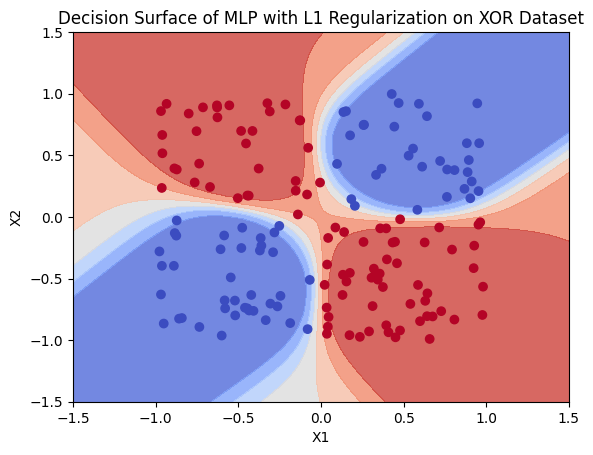

In [29]:

# L1 regularization term
def l1_regularization(weight_matrix, penalty):
    return penalty * np.sign(weight_matrix)


# Define the model architecture with L1 regularization
class NeuralNetworkL1:
    def __init__(self, penalty):
        # Initialize weights and biases
        self.input_size = 2
        self.hidden_size = 4
        self.output_size = 1

        self.weights_input_hidden = np.random.randn(self.input_size, self.hidden_size)
        self.bias_input_hidden = np.zeros((1, self.hidden_size))

        self.weights_hidden_output = np.random.randn(self.hidden_size, self.output_size)
        self.bias_hidden_output = np.zeros((1, self.output_size))

        # L1 regularization penalty
        self.penalty = penalty

    def forward(self, X):
        # Forward pass
        self.hidden_output = sigmoid(np.dot(X, self.weights_input_hidden) + self.bias_input_hidden)
        self.output = sigmoid(np.dot(self.hidden_output, self.weights_hidden_output) + self.bias_hidden_output)
        return self.output


    def backward(self, X, y, lr):
        # Backpropagation
        error = y - self.output
        d_output = error * sigmoid_derivative(self.output)

        error_hidden = np.dot(d_output, self.weights_hidden_output.T)
        d_hidden = error_hidden * sigmoid_derivative(self.hidden_output)

        # Update weights and biases with L1 regularization
        self.weights_hidden_output += (np.dot(self.hidden_output.T, d_output) - l1_regularization(self.weights_hidden_output, self.penalty)) * lr
        self.bias_hidden_output += np.sum(d_output, axis=0, keepdims=True) * lr

        self.weights_input_hidden += (np.dot(X.T, d_hidden) - l1_regularization(self.weights_input_hidden, self.penalty)) * lr
        self.bias_input_hidden += np.sum(d_hidden, axis=0, keepdims=True) * lr

    def train(self, X, y, epochs, lr):
        for epoch in range(epochs):
            output = self.forward(X)
            self.backward(X, y, lr)
            # if epoch % 100 == 0:
            #     loss = np.mean(np.square(y - output))
            #     print(f'Epoch {epoch}: Loss {loss}')

    def predict(self, X):
        return self.forward(X)

# Function to choose the best penalty coefficient using a validation dataset
def choose_best_penalty(X_train, Y_train, X_val, Y_val, penalties):
    best_penalty = None
    best_accuracy = 0

    for penalty in penalties:
        model = NeuralNetworkL1(penalty)
        model.train(X_train, Y_train.reshape(-1, 1), epochs=1500, lr=0.1)
        predictions = np.round(model.predict(X_val))
        accuracy = np.mean(predictions == Y_val.reshape(-1, 1))

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_penalty = penalty

    return best_penalty

# Split validation set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

# Choose the best penalty coefficient
penalties = [0.001, 0.01, 0.1, 1]
best_penalty = choose_best_penalty(X_train, Y_train, X_val, Y_val, penalties)
print(f'Best penalty coefficient: {best_penalty}')

# Train the final model with the best penalty coefficient
model = NeuralNetworkL1(best_penalty)
model.train(X_train, Y_train.reshape(-1, 1), epochs=1500, lr=0.1)

# Evaluate the model
predictions = np.round(model.predict(X_test))
accuracy = np.mean(predictions == Y_test.reshape(-1, 1))
print(f'Test accuracy: {accuracy}')

# Plot decision surface
xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, 100),
                     np.linspace(-1.5, 1.5, 100))
Z2 = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.contourf(xx, yy, Z2, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap=plt.cm.coolwarm)
plt.title('Decision Surface of MLP with L1 Regularization on XOR Dataset')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()


Best penalty coefficient: 0.001
Test accuracy: 0.975


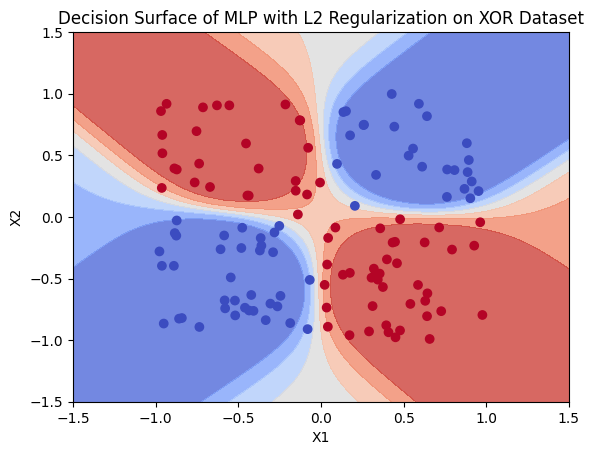

In [30]:

# L2 regularization term
def l2_regularization(weight_matrix, penalty):
    return penalty * weight_matrix

# Define the model architecture with L2 regularization
class NeuralNetworkL2:
    def __init__(self, penalty):
        # Initialize weights and biases
        self.input_size = 2
        self.hidden_size = 4
        self.output_size = 1

        self.weights_input_hidden = np.random.randn(self.input_size, self.hidden_size)
        self.bias_input_hidden = np.zeros((1, self.hidden_size))

        self.weights_hidden_output = np.random.randn(self.hidden_size, self.output_size)
        self.bias_hidden_output = np.zeros((1, self.output_size))

        # L2 regularization penalty
        self.penalty = penalty

    def forward(self, X):
        # Forward pass
        self.hidden_output = sigmoid(np.dot(X, self.weights_input_hidden) + self.bias_input_hidden)
        self.output = sigmoid(np.dot(self.hidden_output, self.weights_hidden_output) + self.bias_hidden_output)
        return self.output

    def backward(self, X, y, lr):
        # Backpropagation
        error = y - self.output
        d_output = error * sigmoid_derivative(self.output)

        error_hidden = np.dot(d_output, self.weights_hidden_output.T)
        d_hidden = error_hidden * sigmoid_derivative(self.hidden_output)

        # Update weights and biases with L2 regularization
        self.weights_hidden_output += (np.dot(self.hidden_output.T, d_output) - l2_regularization(self.weights_hidden_output, self.penalty)) * lr
        self.bias_hidden_output += np.sum(d_output, axis=0, keepdims=True) * lr

        self.weights_input_hidden += (np.dot(X.T, d_hidden) - l2_regularization(self.weights_input_hidden, self.penalty)) * lr
        self.bias_input_hidden += np.sum(d_hidden, axis=0, keepdims=True) * lr

    def train(self, X, y, epochs, lr):
        for epoch in range(epochs):
            output = self.forward(X)
            self.backward(X, y, lr)
            # if epoch % 100 == 0:
            #     loss = np.mean(np.square(y - output))
            #     print(f'Epoch {epoch}: Loss {loss}')

    def predict(self, X):
        return self.forward(X)

# Function to choose the best penalty coefficient using a validation dataset
def choose_best_penalty(X_train, Y_train, X_val, Y_val, penalties):
    best_penalty = None
    best_accuracy = 0

    for penalty in penalties:
        model = NeuralNetworkL2(penalty)
        model.train(X_train, Y_train.reshape(-1, 1), epochs=1500, lr=0.1)
        predictions = np.round(model.predict(X_val))
        accuracy = np.mean(predictions == Y_val.reshape(-1, 1))

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_penalty = penalty

    return best_penalty

# # Split validation set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

# Choose the best penalty coefficient
penalties = [0.001, 0.01, 0.1, 1]
best_penalty = choose_best_penalty(X_train, Y_train, X_val, Y_val, penalties)
print(f'Best penalty coefficient: {best_penalty}')

# Train the final model with the best penalty coefficient
model = NeuralNetworkL2(best_penalty)
model.train(X_train, Y_train.reshape(-1, 1), epochs=1500, lr=0.1)

# Evaluate the model
predictions = np.round(model.predict(X_test))
accuracy = np.mean(predictions == Y_test.reshape(-1, 1))
print(f'Test accuracy: {accuracy}')

# Plot decision surface
xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, 100),
                     np.linspace(-1.5, 1.5, 100))
Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap=plt.cm.coolwarm)
plt.title('Decision Surface of MLP with L2 Regularization on XOR Dataset')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()


Iteration 0, Loss: 0.6931271807599427
Iteration 1000, Loss: 0.5673741983795642
Test Accuracy: 94.5%


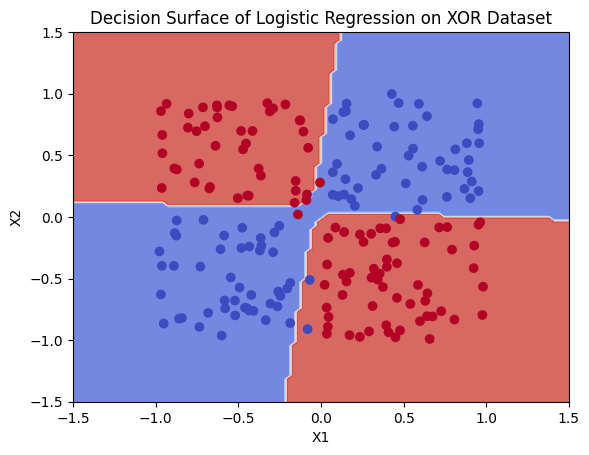

In [31]:
# Generate XOR dataset
np.random.seed(0)
X_train = np.random.rand(200, 2) * 2 - 1  # Random points in [-1, 1]
y_train = np.logical_xor(X_train[:, 0] > 0, X_train[:, 1] > 0).astype(int)  # XOR labels

X_test = np.random.rand(200, 2) * 2 - 1
y_test = np.logical_xor(X_test[:, 0] > 0, X_test[:, 1] > 0).astype(int)

# Add additional features
def add_additional_features(X):
    x1x2 = X[:, 0] * X[:, 1]
    x1_squared = X[:, 0] ** 2
    x2_squared = X[:, 1] ** 2
    return np.column_stack((X, x1x2, x1_squared, x2_squared))

X_train = add_additional_features(X_train)
X_test = add_additional_features(X_test)


# Initialize weights
def initialize_weights(dim):
    return np.zeros((dim, 1))

# Forward propagation
def forward_propagation(X, theta):
    return sigmoid(np.dot(X, theta))

# Compute loss
def compute_loss(y_pred, y_true):
    m = y_true.shape[0]
    epsilon = 1e-5  # to avoid division by zero
    return -1 / m * np.sum(y_true * np.log(y_pred + epsilon) + (1 - y_true) * np.log(1 - y_pred + epsilon))

# Backward propagation
def backward_propagation(X, y_pred, y_true):
    m = y_true.shape[0]
    return 1 / m * np.dot(X.T, y_pred - y_true)

# Gradient descent
def gradient_descent(X, y, theta, learning_rate, num_iterations):
    losses = []
    for i in range(num_iterations):
        y_pred = forward_propagation(X, theta)
        loss = compute_loss(y_pred, y)
        gradient = backward_propagation(X, y_pred, y)
        theta -= learning_rate * gradient
        losses.append(loss)
        if i % 1000 == 0:
            print(f"Iteration {i}, Loss: {loss}")
    return theta, losses

# Train logistic regression model
learning_rate = 0.01
num_iterations = 1500
theta = initialize_weights(X_train.shape[1])
theta, losses = gradient_descent(X_train, y_train.reshape(-1, 1), theta, learning_rate, num_iterations)



# Predictions
def predict(X, theta):
    return np.round(forward_propagation(X, theta))

# Test accuracy
def accuracy(predictions, labels):
    return np.mean(predictions == labels.reshape(-1, 1)) * 100

# Make predictions on test set
predictions = predict(X_test, theta)
test_acc = accuracy(predictions, y_test)
print(f"Test Accuracy: {test_acc}%")

# Generate grid points for visualization
xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, 100), np.linspace(-1.5, 1.5, 100))
grid_X = np.c_[xx.ravel(), yy.ravel()]
grid_X = add_additional_features(grid_X)

# Compute predictions for grid points
grid_predictions = predict(grid_X, theta)
grid_predictions = grid_predictions.reshape(xx.shape)

# Plot decision surface
plt.contourf(xx, yy, grid_predictions, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.coolwarm)
plt.title('Decision Surface of Logistic Regression on XOR Dataset')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()


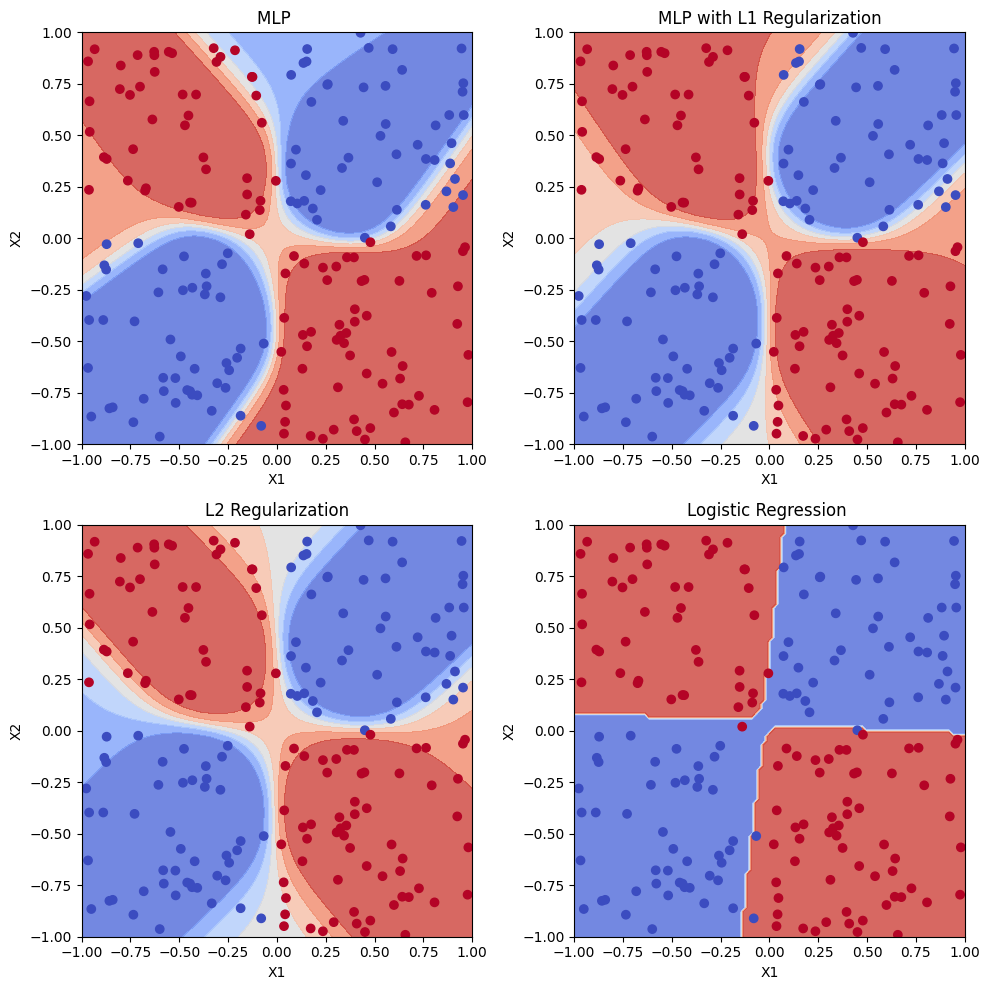

In [32]:
# Generate grid points for visualization
xx, yy = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
grid_X = np.c_[xx.ravel(), yy.ravel()]

# Define a function to plot decision surface
def plot_decision_surface(xx, yy, Z, title, ax):
    ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.coolwarm)
    ax.set_title(title)
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')


fig, axs = plt.subplots(2, 2, figsize=(10, 10))

plot_decision_surface(xx, yy, Z1, 'MLP ', ax=axs[0, 0])
plot_decision_surface(xx, yy, Z2, 'MLP with L1 Regularization', ax=axs[0, 1])
plot_decision_surface(xx, yy, Z, 'L2 Regularization', ax=axs[1, 0])
plot_decision_surface(xx, yy, grid_predictions, 'Logistic Regression ', ax=axs[1, 1])

plt.tight_layout()
plt.show()


# **Comparison of Four Models on XOR Dataset:**

1. **Multi-Layer Perceptron (MLP):** The decision boundaries in the contour plot exhibit significant uncertainty, with lighter areas indicating less confidence in predictions. Despite this, the model effectively captures the XOR function and achieves commendable accuracy, standing at 96%. However, the boundaries are somewhat distorted and unclear.

2. **MLP with L1 Regularization:** Compared to the unregularized MLP, this model demonstrates improvement. The contour plot shows darker areas, suggesting clearer decision boundaries. As a result, the accuracy is 96%. The regularization helps in enhancing model performance by reducing overfitting and promoting sparsity in weights.

3. **MLP with L2 Regularization:** Notably, this model presents a more symmetric plot and effectively captures the XOR function's intricacies. The contour plot exhibits smoother decision boundaries compared to previous models. Consequently, accuracy sees a notable boost, reaching 97.5%. L2 regularization aids in controlling overfitting by penalizing large weights, resulting in a more robust model.

4. **Logistic Regression:** Among the models evaluated, logistic regression demonstrates the most distinct decision boundaries in the contour plot. Despite its simplicity compared to neural networks, it remarkably represents the XOR function. However, its accuracy falls slightly behind the MLP models at 94.5%. Logistic regression provides a clear representation of the XOR function's classification, albeit with slightly lower accuracy compared to MLPs, suggesting its effectiveness in handling linearly separable data.

In summary, while all models achieve relatively high accuracy on the XOR dataset, they differ in terms of decision boundary clarity and symmetry. Regularized MLPs show improvement over their unregularized counterpart, with L2 regularization yielding the highest accuracy and smoothest decision boundaries. Logistic regression, although simpler, provides a clear representation of the XOR function but with slightly lower accuracy than MLPs. Each model showcases distinct characteristics in handling the XOR dataset, highlighting the importance of considering model complexity and regularization techniques in achieving optimal performance.